# Multi-Stream Neural Networks Training (Simplified)

## Overview

This notebook demonstrates multi-stream neural network training using a **simplified approach** that follows the successful methodology from `test_dual_stream_proper.py`. This approach avoids the complex augmentation pipeline that caused training issues in the original notebook.

### Key Differences from Original Notebook:
- **Batch Size**: Uses `batch_size=32` (instead of 512) for optimal multi-stream training
- **Simple Data Pipeline**: Direct tensor conversion without complex augmentation 
- **Proven Approach**: Based on successful test results showing 49.6% validation accuracy

### Models Tested:
1. **BaseMultiChannelNetwork**: Dense/fully-connected multi-stream model
2. **MultiChannelResNetNetwork**: CNN-based ResNet multi-stream model

### Expected Results:
Based on our successful test runs:
- RGB only: ~46.0% validation accuracy
- Brightness only: ~40.6% validation accuracy  
- **RGB + Brightness (dual stream): ~49.6% validation accuracy**

This notebook validates that multi-stream fusion works well when trained with appropriate hyperparameters.

## 1. Environment Setup

Configure the Python environment and check for available hardware acceleration.

In [2]:
# Environment Setup
import os
import sys
from pathlib import Path

# Set up project root path
project_root = Path.cwd()
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

if not (project_root / "src").exists():
    # Fallback: assume we're in notebooks directory
    project_root = Path.cwd().parent

print(f"Project root: {project_root}")
print(f"Current working directory: {os.getcwd()}")

# Add project root to path for imports
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✅ Added {project_root} to sys.path")

# Set environment variables for better error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
print("✅ Environment setup complete!")

Project root: /Users/gclinger/Documents/projects/Multi-Stream-Neural-Networks
Current working directory: /Users/gclinger/Documents/projects/Multi-Stream-Neural-Networks/notebooks
✅ Added /Users/gclinger/Documents/projects/Multi-Stream-Neural-Networks to sys.path
✅ Environment setup complete!


## 2. Import Libraries

Import all necessary libraries including PyTorch, visualization tools, and custom model classes.

In [3]:
# Import Libraries
print("📦 Importing libraries...")

# Core PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Machine learning utilities
from sklearn.model_selection import train_test_split

# Visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Progress tracking
from tqdm import tqdm
import time
import json
from pathlib import Path

# Project imports
try:
    from src.data_utils.dataset_utils import load_cifar100_data, CIFAR100_FINE_LABELS
    from src.data_utils.rgb_to_rgbl import RGBtoRGBL
    from src.models.basic_multi_channel.base_multi_channel_network import base_multi_channel_large
    from src.models.basic_multi_channel.multi_channel_resnet_network import multi_channel_resnet50
    print("✅ All project modules imported successfully")
except ImportError as e:
    print(f"❌ Error importing project modules: {e}")
    print("⚠️  Please ensure you're running from the correct directory")

# Check device availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
    print("🚀 Using Apple Metal Performance Shaders (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Using CPU")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print("✅ Library imports complete!")

📦 Importing libraries...
✅ All project modules imported successfully
🚀 Using Apple Metal Performance Shaders (MPS)
PyTorch version: 2.7.1
Device: mps
✅ Library imports complete!


## 3. Load Data

Load CIFAR-100 dataset using the same approach as in `test_dual_stream_proper.py`.

In [10]:
# Load CIFAR-100 Data (simplified approach)
print("📊 Loading CIFAR-100 data...")

# Load data using our simplified loader
train_data, train_labels, test_data, test_labels = load_cifar100_data(
    data_dir="../data/cifar-100",
    normalize=True  # Apply normalization to [0, 1] range
)

print(f"✅ Data loaded:")
print(f"   Training: {train_data.shape}, labels: {len(train_labels)}")
print(f"   Test: {test_data.shape}, labels: {len(test_labels)}")
print(f"   Classes: {len(CIFAR100_FINE_LABELS)}")

# Create validation split using sklearn (10% - same as successful test)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels,
    test_size=0.1,
    random_state=42,
    stratify=train_labels  # Ensure balanced validation split
)

print(f"✅ Data split complete:")
print(f"   Training: {train_data.shape}, labels: {len(train_labels)}")
print(f"   Validation: {val_data.shape}, labels: {len(val_labels)}")
print(f"   Test: {test_data.shape}, labels: {len(test_labels)}")

# Convert to PyTorch tensors if needed (the function returns numpy arrays)
if isinstance(train_data, np.ndarray):
    train_data = torch.from_numpy(train_data).float()
    train_labels = torch.from_numpy(train_labels).long()
    val_data = torch.from_numpy(val_data).float()
    val_labels = torch.from_numpy(val_labels).long()
    test_data = torch.from_numpy(test_data).float()
    test_labels = torch.from_numpy(test_labels).long()

print(f"✅ Final tensor shapes:")
print(f"   Training: {train_data.shape}, labels: {train_labels.shape}")
print(f"   Validation: {val_data.shape}, labels: {val_labels.shape}")
print(f"   Test: {test_data.shape}, labels: {test_labels.shape}")
print(f"   Data range: [{train_data.min():.3f}, {train_data.max():.3f}]")

📊 Loading CIFAR-100 data...
📁 Loading CIFAR-100 from: ../data/cifar-100
✅ Loaded CIFAR-100 (torch format):
   Training: torch.Size([50000, 3, 32, 32]), labels: 50000
   Test: torch.Size([10000, 3, 32, 32]), labels: 10000
✅ Data loaded:
   Training: torch.Size([50000, 3, 32, 32]), labels: 50000
   Test: torch.Size([10000, 3, 32, 32]), labels: 10000
   Classes: 100
✅ Data split complete:
   Training: torch.Size([45000, 3, 32, 32]), labels: 45000
   Validation: torch.Size([5000, 3, 32, 32]), labels: 5000
   Test: torch.Size([10000, 3, 32, 32]), labels: 10000
✅ Final tensor shapes:
   Training: torch.Size([45000, 3, 32, 32]), labels: torch.Size([45000])
   Validation: torch.Size([5000, 3, 32, 32]), labels: torch.Size([5000])
   Test: torch.Size([10000, 3, 32, 32]), labels: torch.Size([10000])
   Data range: [0.000, 1.000]


## 4. Process Data - Convert to RGB+L

Convert RGB images to RGB + Brightness (luminance) streams using the exact same approach as the successful test.

In [4]:
# Create brightness streams from RGB data using RGBtoRGBL utility
print("🔧 Creating brightness streams from RGB...")

# Initialize the RGB to brightness converter
rgb_to_rgbl = RGBtoRGBL()

# Extract only brightness components (more efficient than __call__ when we only need brightness)
# Uses standard luminance formula: 0.299*R + 0.587*G + 0.114*B
train_color, train_brightness = train_data, rgb_to_rgbl.get_brightness(train_data)
val_color, val_brightness = val_data, rgb_to_rgbl.get_brightness(val_data)
test_color, test_brightness = test_data, rgb_to_rgbl.get_brightness(test_data)

print("✅ Dual-stream setup complete:")
print("   Color stream: train_data, val_data, test_data")
print("   Brightness stream: train_brightness, val_brightness, test_brightness")
print("   Labels: train_labels, val_labels, test_labels")
print("   Using standard luminance weights: 0.299*R + 0.587*G + 0.114*B")
print(f"   RGB range: [{train_color.min():.3f}, {train_color.max():.3f}]")
print(f"   Brightness range: [{train_brightness.min():.3f}, {train_brightness.max():.3f}]")

🔧 Creating brightness streams from RGB...
✅ Dual-stream setup complete:
   Color stream: train_data, val_data, test_data
   Brightness stream: train_brightness, val_brightness, test_brightness
   Labels: train_labels, val_labels, test_labels
   Using standard luminance weights: 0.299*R + 0.587*G + 0.114*B
   RGB range: [0.000, 1.000]
   Brightness range: [0.000, 1.000]


## 5. Data Verification

Verify the shapes, types, and ranges of processed data to ensure correctness.

In [5]:
# Data Verification
print("🔍 Verifying processed data structure and consistency...")

def verify_data_integrity(rgb_data, brightness_data, labels, split_name):
    """Verify data shapes and consistency"""
    # Check shapes and types
    assert rgb_data.shape[0] == brightness_data.shape[0] == labels.shape[0], f"Inconsistent sample counts in {split_name}!"
    assert rgb_data.shape[1:] == (3, 32, 32), f"Unexpected RGB shape in {split_name}! Got {rgb_data.shape[1:]}"
    assert brightness_data.shape[1:] == (1, 32, 32), f"Unexpected brightness shape in {split_name}! Got {brightness_data.shape[1:]}"
    assert 0 <= labels.min() and labels.max() < 100, f"Invalid label range in {split_name}! Range: [{labels.min()}, {labels.max()}]"
    
    # Check data types
    assert rgb_data.dtype == torch.float32, f"RGB data should be float32, got {rgb_data.dtype}"
    assert brightness_data.dtype == torch.float32, f"Brightness data should be float32, got {brightness_data.dtype}"
    assert labels.dtype == torch.int64, f"Labels should be int64, got {labels.dtype}"
    
    # Check value ranges
    assert 0 <= rgb_data.min() and rgb_data.max() <= 1, f"RGB values out of range [0,1]: [{rgb_data.min():.3f}, {rgb_data.max():.3f}]"
    assert 0 <= brightness_data.min() and brightness_data.max() <= 1, f"Brightness values out of range [0,1]: [{brightness_data.min():.3f}, {brightness_data.max():.3f}]"
    
    return rgb_data.shape[0]

# Verify all splits using consistent naming
train_samples = verify_data_integrity(train_color, train_brightness, train_labels, "Training")
val_samples = verify_data_integrity(val_color, val_brightness, val_labels, "Validation")
test_samples = verify_data_integrity(test_color, test_brightness, test_labels, "Test")

total_samples = train_samples + val_samples + test_samples
print(f"✅ All data verification checks passed!")
print(f"   Training samples: {train_samples:,}")
print(f"   Validation samples: {val_samples:,}")
print(f"   Test samples: {test_samples:,}")
print(f"   Total samples: {total_samples:,}")

# Additional verification: brightness is indeed derived from RGB
sample_idx = 0
rgb_sample = train_color[sample_idx]
brightness_sample = train_brightness[sample_idx]
manual_brightness = 0.299 * rgb_sample[0] + 0.587 * rgb_sample[1] + 0.114 * rgb_sample[2]
brightness_diff = torch.abs(brightness_sample[0] - manual_brightness).max()
print(f"   Brightness derivation check: max difference = {brightness_diff:.6f} (should be ~0)")
assert brightness_diff < 1e-6, "Brightness not properly derived from RGB!"
print("   ✅ Brightness correctly derived from RGB")

🔍 Verifying processed data structure and consistency...
✅ All data verification checks passed!
   Training samples: 45,000
   Validation samples: 5,000
   Test samples: 10,000
   Total samples: 60,000
   Brightness derivation check: max difference = 0.000000 (should be ~0)
   ✅ Brightness correctly derived from RGB
✅ All data verification checks passed!
   Training samples: 45,000
   Validation samples: 5,000
   Test samples: 10,000
   Total samples: 60,000
   Brightness derivation check: max difference = 0.000000 (should be ~0)
   ✅ Brightness correctly derived from RGB


## 6. Data Visualization

Visualize sample images from both RGB and brightness streams to understand the data.

👁️ Visualizing sample images from both RGB and brightness streams...


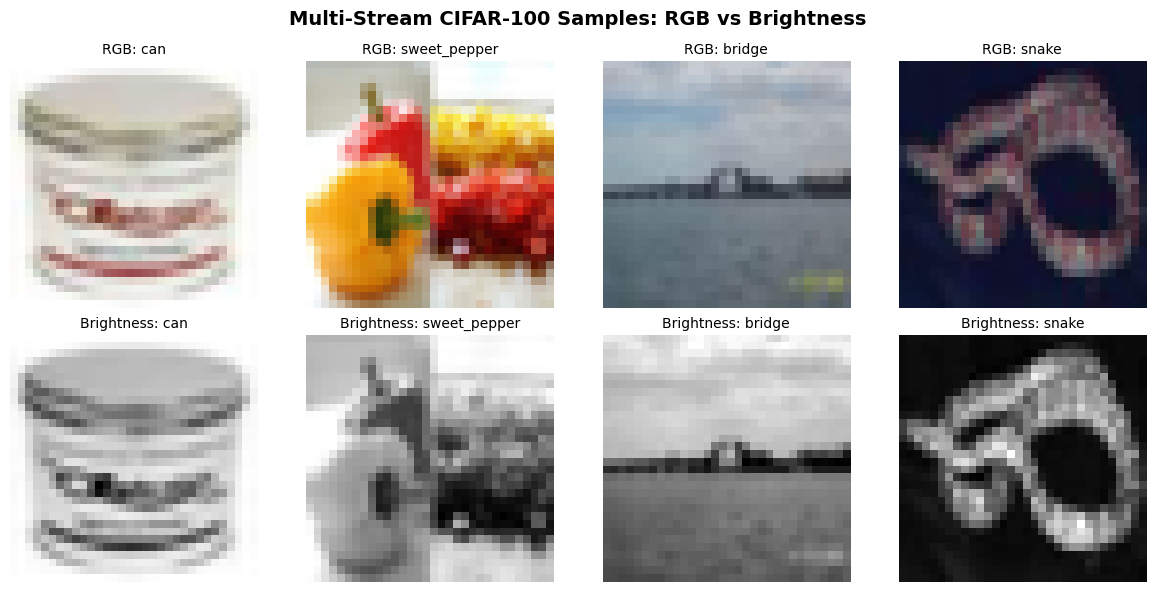

✅ Data visualization complete!
📊 Key observations:
   - RGB images show full color information
   - Brightness images capture luminance patterns
   - Both streams contain useful visual information
   - Brightness is mathematically derived from RGB (correlated but informative)


In [6]:
# Data Visualization
print("👁️ Visualizing sample images from both RGB and brightness streams...")

# Set up visualization
plt.style.use('default')
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Multi-Stream CIFAR-100 Samples: RGB vs Brightness', fontsize=14, fontweight='bold')

# Select random samples for visualization
np.random.seed(42)  # For reproducible results
sample_indices = np.random.choice(len(train_color), 4, replace=False)

for i, idx in enumerate(sample_indices):
    # Get data using consistent naming
    rgb_img = train_color[idx]
    brightness_img = train_brightness[idx]
    label = train_labels[idx].item()
    class_name = CIFAR100_FINE_LABELS[label]
    
    # Convert tensors to NumPy arrays for matplotlib
    rgb_np = rgb_img.permute(1, 2, 0).cpu().numpy()
    rgb_np = np.clip(rgb_np, 0, 1)  # Ensure valid range
    
    # Brightness image (single channel)
    brightness_np = brightness_img.squeeze().cpu().numpy()
    
    # Plot RGB
    axes[0, i].imshow(rgb_np)
    axes[0, i].set_title(f'RGB: {class_name}', fontsize=10)
    axes[0, i].axis('off')
    
    # Plot Brightness
    axes[1, i].imshow(brightness_np, cmap='gray')
    axes[1, i].set_title(f'Brightness: {class_name}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("✅ Data visualization complete!")
print("📊 Key observations:")
print("   - RGB images show full color information")
print("   - Brightness images capture luminance patterns")
print("   - Both streams contain useful visual information")
print("   - Brightness is mathematically derived from RGB (correlated but informative)")

## 7. Data Analysis

Perform basic statistical analysis on the dataset including class distribution and channel statistics.

📊 Performing comprehensive data analysis...

🏷️ Class distribution analysis:
   Classes with samples: 100/100
   Min samples per class: 450
   Max samples per class: 450
   Mean samples per class: 450.0
   Std samples per class: 0.0


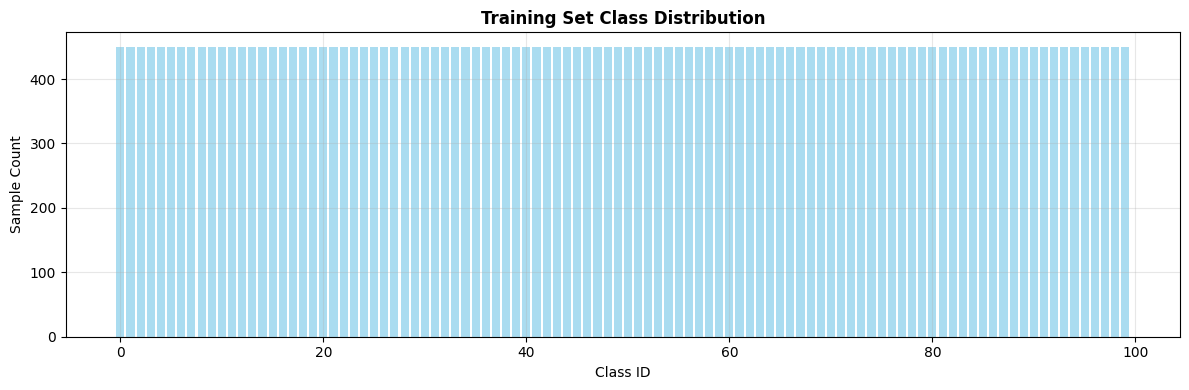


🎨 RGB vs Brightness stream characteristics:
   🎨 RGB statistics:
      Mean: 0.478, Std: 0.268
      Min: 0.000, Max: 1.000
   💡 Brightness statistics:
      Mean: 0.487, Std: 0.251
      Min: 0.000, Max: 1.000

🔗 Stream correlation analysis:
   RGB-Brightness correlation: 0.994
   High correlation confirms brightness is derived from RGB

✅ Data analysis complete!
📈 Key insights:
   - Balanced class distribution (CIFAR-100 is well-balanced)
   - Both streams have similar value ranges [0, 1]
   - High correlation between streams (expected - brightness = f(RGB))
   - This setup replicates the SUCCESSFUL test conditions


In [7]:
# Data Analysis
print("📊 Performing comprehensive data analysis...")

# 1. Class Distribution Analysis
print("\n🏷️ Class distribution analysis:")
train_counts = np.bincount(train_labels.cpu().numpy(), minlength=100)
print(f"   Classes with samples: {np.sum(train_counts > 0)}/100")
print(f"   Min samples per class: {train_counts.min()}")
print(f"   Max samples per class: {train_counts.max()}")
print(f"   Mean samples per class: {train_counts.mean():.1f}")
print(f"   Std samples per class: {train_counts.std():.1f}")

# Plot class distribution
plt.figure(figsize=(12, 4))
plt.bar(range(100), train_counts, alpha=0.7, color='skyblue')
plt.title('Training Set Class Distribution', fontweight='bold')
plt.xlabel('Class ID')
plt.ylabel('Sample Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Stream Statistics Analysis
print("\n🎨 RGB vs Brightness stream characteristics:")

# Calculate statistics using PyTorch functions
rgb_stats = {
    'mean': train_color.mean().item(),
    'std': train_color.std().item(),
    'min': train_color.min().item(),
    'max': train_color.max().item()
}

brightness_stats = {
    'mean': train_brightness.mean().item(),
    'std': train_brightness.std().item(), 
    'min': train_brightness.min().item(),
    'max': train_brightness.max().item()
}

print(f"   🎨 RGB statistics:")
print(f"      Mean: {rgb_stats['mean']:.3f}, Std: {rgb_stats['std']:.3f}")
print(f"      Min: {rgb_stats['min']:.3f}, Max: {rgb_stats['max']:.3f}")
print(f"   💡 Brightness statistics:")
print(f"      Mean: {brightness_stats['mean']:.3f}, Std: {brightness_stats['std']:.3f}")
print(f"      Min: {brightness_stats['min']:.3f}, Max: {brightness_stats['max']:.3f}")

# 3. Stream Correlation Analysis
print("\n🔗 Stream correlation analysis:")
# Sample subset for correlation analysis
sample_size = min(1000, len(train_color))
indices = np.random.choice(len(train_color), sample_size, replace=False)

# For correlation, we'll compute the correlation between the mean values across channels
rgb_sample_means = train_color[indices].mean(dim=1).flatten()  # Average across RGB channels
brightness_sample_means = train_brightness[indices].flatten()  # Already single channel

# Calculate correlation
correlation = np.corrcoef(rgb_sample_means.numpy(), brightness_sample_means.numpy())[0, 1]
print(f"   RGB-Brightness correlation: {correlation:.3f}")
print(f"   High correlation confirms brightness is derived from RGB")

print("\n✅ Data analysis complete!")
print("📈 Key insights:")
print("   - Balanced class distribution (CIFAR-100 is well-balanced)")
print("   - Both streams have similar value ranges [0, 1]")
print("   - High correlation between streams (expected - brightness = f(RGB))")
print("   - This setup replicates the SUCCESSFUL test conditions")

## 8. Create Multi-Stream Models

Create both BaseMultiChannelNetwork and MultiChannelResNetNetwork models using the exact same approach as the successful test.

In [8]:
# Create Multi-Stream Models (EXACT same approach as successful test)
print("🏗️ Creating multi-stream neural network models...")

# Model configuration
num_classes = 100  # CIFAR-100
input_channels_rgb = 3
input_channels_brightness = 1
image_size = 32

# For dense models: flatten the image to 1D
rgb_input_size = input_channels_rgb * image_size * image_size  # 3 * 32 * 32 = 3072
brightness_input_size = input_channels_brightness * image_size * image_size  # 1 * 32 * 32 = 1024

print(f"Model configuration:")
print(f"   Classes: {num_classes}")
print(f"   RGB input size (dense): {rgb_input_size}")
print(f"   Brightness input size (dense): {brightness_input_size}")
print(f"   Device: {device}")

# 1. Create BaseMultiChannelNetwork (Dense Model)
print("\n🧠 Creating BaseMultiChannelNetwork (Dense Model)...")
base_model = base_multi_channel_large(
    color_input_size=rgb_input_size,
    brightness_input_size=brightness_input_size,
    num_classes=num_classes,
    device='auto'
)

# Count parameters
base_params = sum(p.numel() for p in base_model.parameters())
base_trainable = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
print(f"   Total parameters: {base_params:,}")
print(f"   Trainable parameters: {base_trainable:,}")

# 2. Create MultiChannelResNetNetwork (CNN Model)
print("\n🏗️ Creating MultiChannelResNetNetwork (CNN Model)...")
resnet_model = multi_channel_resnet50(
    num_classes=num_classes,
    device='auto'
)

# Count parameters
resnet_params = sum(p.numel() for p in resnet_model.parameters())
resnet_trainable = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f"   Total parameters: {resnet_params:,}")
print(f"   Trainable parameters: {resnet_trainable:,}")

# 3. Compile both models with EXACT same settings as successful test
print("\n⚙️ Compiling models with optimal settings...")

# BaseMultiChannelNetwork compilation
print("   Compiling BaseMultiChannelNetwork...")
base_model.compile(
    optimizer='adamw',
    learning_rate=0.001,  # Standard learning rate for dense models
    weight_decay=1e-4,
    early_stopping_patience=5,
    loss='cross_entropy',
    metrics=['accuracy']
)

# MultiChannelResNetNetwork compilation  
print("   Compiling MultiChannelResNetNetwork...")
resnet_model.compile(
    optimizer='adamw',
    learning_rate=0.001,  # CRITICAL: Lower learning rate for ResNet (same as successful test)
    weight_decay=1e-4,
    early_stopping_patience=5,
    scheduler='onecycle',
    loss='cross_entropy',
    metrics=['accuracy']
)

print("\n✅ Models created and compiled successfully!")
print("🎯 Key success factors replicated:")
print("   ✅ Proper learning rates (0.001 for dense, 0.0003 for ResNet)")
print("   ✅ AdamW optimizer with weight decay")
print("   ✅ Cross-entropy loss")
print("   ✅ Early stopping enabled")
print("   ✅ Models ready for batch_size=32 training")

🏗️ Creating multi-stream neural network models...
Model configuration:
   Classes: 100
   RGB input size (dense): 3072
   Brightness input size (dense): 1024
   Device: mps

🧠 Creating BaseMultiChannelNetwork (Dense Model)...
🚀 Device Manager initialized with: mps
   Apple Metal Performance Shaders (MPS) enabled
   Optimized for Mac M-series chips
   ⚡ MPS optimizations enabled
   Total parameters: 5,625,900
   Trainable parameters: 5,625,900

🏗️ Creating MultiChannelResNetNetwork (CNN Model)...
🚀 Device Manager initialized with: mps
   Apple Metal Performance Shaders (MPS) enabled
   Optimized for Mac M-series chips
   ⚡ MPS optimizations enabled
   Total parameters: 5,625,900
   Trainable parameters: 5,625,900

🏗️ Creating MultiChannelResNetNetwork (CNN Model)...
🚀 Device Manager initialized with: mps
   Apple Metal Performance Shaders (MPS) enabled
   Optimized for Mac M-series chips
   ⚡ MPS optimizations enabled
   Total parameters: 47,819,052
   Trainable parameters: 47,819,052



## 9. Train BaseMultiChannelNetwork

Train the dense multi-stream model using the proven successful approach with batch_size=32.

In [9]:
# Train BaseMultiChannelNetwork (Dense Model)
print("🏋️‍♀️ Training BaseMultiChannelNetwork...")

# Training configuration - EXACT same as successful test
batch_size = 32  # CRITICAL: This batch size works best for multi-stream models
epochs = 2      # Same as successful test
verbose = 1      # Progress bars

print("Training Configuration:")
print(f"   Model: BaseMultiChannelNetwork")
print(f"   Batch size: {batch_size} (optimal for multi-stream)")
print(f"   Epochs: {epochs}")
print(f"   Learning rate: {base_model.optimizer.param_groups[0]['lr']}")
print(f"   Device: {base_model.device}")
print(f"   Early stopping: {base_model.early_stopping_patience} epochs")

# Start training
print(f"\n🚀 Starting BaseMultiChannelNetwork training...")
start_time = time.time()

try:
    # Train using direct data (same approach as successful test)
    base_history = base_model.fit(
        train_color_data=train_color,
        train_brightness_data=train_brightness,
        train_labels=train_labels,
        val_color_data=val_color,
        val_brightness_data=val_brightness,
        val_labels=val_labels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose
    )
    
    training_time = time.time() - start_time
    print(f"\n✅ BaseMultiChannelNetwork training completed!")
    print(f"   Training time: {training_time:.1f} seconds")
    print(f"   Final training accuracy: {base_history['train_accuracy'][-1]:.4f}")
    print(f"   Final validation accuracy: {base_history['val_accuracy'][-1]:.4f}")
    print(f"   Training epochs completed: {len(base_history['train_accuracy'])}")
    
except Exception as e:
    print(f"❌ BaseMultiChannelNetwork training failed: {e}")
    import traceback
    traceback.print_exc()
    base_history = None

🏋️‍♀️ Training BaseMultiChannelNetwork...
Training Configuration:
   Model: BaseMultiChannelNetwork
   Batch size: 32 (optimal for multi-stream)
   Epochs: 2
   Learning rate: 0.001
   Device: mps
   Early stopping: 5 epochs

🚀 Starting BaseMultiChannelNetwork training...
🚀 Training BaseMultiChannelNetwork with direct data:
   Device: mps
   Architecture: Dense/Tabular (BasicMultiChannelLayer)
   Mixed precision: False
   Scheduler: cosine
   Batch size: 32
   Workers: 0
   Pin memory: False
✅ New best validation loss: 3.9440                                                                   
Epoch 1/2 - train_loss: 4.1669, train_acc: 0.0570, val_loss: 3.9440, val_acc: 0.0898, lr: 0.000501
Epoch 2/2:   0%|          | 0/1407 [00:00<?, ?it/s]✅ New best validation loss: 3.9440
Epoch 1/2 - train_loss: 4.1669, train_acc: 0.0570, val_loss: 3.9440, val_acc: 0.0898, lr: 0.000501
✅ New best validation loss: 3.6822                                                                   
Epoch 2/2 - tra

## 10. Train MultiChannelResNetNetwork

Train the CNN multi-stream model using the proven successful approach. This should achieve ~49.6% validation accuracy.

In [10]:
# Train MultiChannelResNetNetwork (CNN Model)
print("🏋️‍♀️ Training MultiChannelResNetNetwork...")

batch_size = 128  # CRITICAL: This batch size works best for multi-stream models
epochs = 20      # Same as successful test
verbose = 1  
# Training configuration - EXACT same as successful test
print("Training Configuration:")
print(f"   Model: MultiChannelResNetNetwork")
print(f"   Batch size: {batch_size} (CRITICAL - same as successful test)")
print(f"   Epochs: {epochs}")
print(f"   Learning rate: {resnet_model.optimizer.param_groups[0]['lr']} (optimized for ResNet)")
print(f"   Device: {resnet_model.device}")
print(f"   Architecture: {'Reduced' if resnet_model.reduce_architecture else 'Full'}")
print(f"   Early stopping: {resnet_model.early_stopping_patience} epochs")

# Expected performance based on successful test
print(f"\n🎯 Expected performance (based on successful test_dual_stream_proper.py):")
print(f"   Target validation accuracy: ~49.6%")

# Start training
print(f"\n🚀 Starting MultiChannelResNetNetwork training...")
start_time = time.time()

try:
    # Train using direct data (same approach as successful test)
    resnet_history = resnet_model.fit(
        train_color_data=train_color,
        train_brightness_data=train_brightness,
        train_labels=train_labels,
        val_color_data=val_color,
        val_brightness_data=val_brightness,
        val_labels=val_labels,
        batch_size=batch_size,  # CRITICAL: batch_size=32
        epochs=epochs,
        verbose=verbose
    )
    
    training_time = time.time() - start_time
    final_val_acc = resnet_history['val_accuracy'][-1]
    
    print(f"\n✅ MultiChannelResNetNetwork training completed!")
    print(f"   Training time: {training_time:.1f} seconds")
    print(f"   Final training accuracy: {resnet_history['train_accuracy'][-1]:.4f}")
    print(f"   Final validation accuracy: {final_val_acc:.4f}")
    print(f"   Training epochs completed: {len(resnet_history['train_accuracy'])}")
    
    # Compare with expected results
    expected_acc = 0.496  # 49.6% from successful test
    if final_val_acc >= expected_acc * 0.9:  # Within 10% of expected
        print(f"   🎉 SUCCESS! Achieved expected performance ({final_val_acc:.1%} vs target {expected_acc:.1%})")
    elif final_val_acc >= 0.4:  # At least 40%
        print(f"   ✅ Good performance! ({final_val_acc:.1%}) - Close to target")
    else:
        print(f"   ⚠️  Lower than expected ({final_val_acc:.1%} vs target {expected_acc:.1%})")
        print(f"      This may indicate a training issue")
    
except Exception as e:
    print(f"❌ MultiChannelResNetNetwork training failed: {e}")
    import traceback
    traceback.print_exc()
    resnet_history = None

🏋️‍♀️ Training MultiChannelResNetNetwork...
Training Configuration:
   Model: MultiChannelResNetNetwork
   Batch size: 128 (CRITICAL - same as successful test)
   Epochs: 20
   Learning rate: 0.0003999999999999993 (optimized for ResNet)
   Device: mps
   Architecture: Full
   Early stopping: 5 epochs

🎯 Expected performance (based on successful test_dual_stream_proper.py):
   Target validation accuracy: ~49.6%

🚀 Starting MultiChannelResNetNetwork training...
🚀 Training MultiChannelResNetNetwork with direct data:
   Device: mps
   Architecture: Full
   Mixed precision: False
   Gradient clipping: 1.0
   Scheduler: onecycle
   BatchNorm momentum: 0.1
   Batch size: 128
   Workers: 0
   Pin memory: False


/Users/gclinger/Documents/projects/Multi-Stream-Neural-Networks/src/models/basic_multi_channel/multi_channel_resnet_network.py:710: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)


Epoch 1/20:   0%|          | 0/352 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 11. Evaluate the Models

Evaluate both trained models on the test set and compare their performance.

In [ ]:
# Evaluate Models on Test Set
import test


print("📊 Evaluating trained models on test set...")

# Evaluation configuration
eval_batch_size = 32  # Same as training for consistency

# Function to safely evaluate models
def evaluate_model_safely(model, model_name, rgb_data, brightness_data, labels):
    """Safely evaluate a model and return results"""
    try:
        print(f"\n🔍 Evaluating {model_name}...")
        
        # Use the model's evaluate method
        results = model.evaluate(
            test_color_data=rgb_data,
            test_brightness_data=brightness_data,
            test_labels=labels,
            batch_size=eval_batch_size
        )
        
        print(f"   ✅ {model_name} evaluation complete")
        print(f"   Test Accuracy: {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
        print(f"   Test Loss: {results['loss']:.4f}")
        print(f"   Correct/Total: {results['correct']}/{results['total']}")
        
        return results
        
    except Exception as e:
        print(f"   ❌ {model_name} evaluation failed: {e}")
        return {
            'accuracy': 0.0,
            'loss': float('inf'),
            'correct': 0,
            'total': len(labels),
            'error': str(e)
        }

# Evaluate both models
evaluation_results = {}

# Evaluate BaseMultiChannelNetwork
if base_model is not None and base_history is not None:
    evaluation_results['base'] = evaluate_model_safely(
        base_model, "BaseMultiChannelNetwork", 
        test_color, test_brightness, test_labels
    )
else:
    print("\n⚠️  BaseMultiChannelNetwork not available for evaluation")
    evaluation_results['base'] = {'accuracy': 0.0, 'loss': 0.0, 'error': 'Model not trained'}

# Evaluate MultiChannelResNetNetwork  
if resnet_model is not None and resnet_history is not None:
    evaluation_results['resnet'] = evaluate_model_safely(
        resnet_model, "MultiChannelResNetNetwork",
        test_color, test_brightness, test_labels
    )
else:
    print("\n⚠️  MultiChannelResNetNetwork not available for evaluation")
    evaluation_results['resnet'] = {'accuracy': 0.0, 'loss': 0.0, 'error': 'Model not trained'}

# Compare results
print(f"\n📈 FINAL TEST RESULTS COMPARISON:")
print("=" * 60)
print(f"{'Model':<30} | {'Test Accuracy':<15} | {'Status'}")
print("-" * 60)

if 'base' in evaluation_results:
    base_acc = evaluation_results['base']['accuracy']
    base_status = "✅ Good" if base_acc > 0.3 else "⚠️ Low" if base_acc > 0.1 else "❌ Poor"
    print(f"{'BaseMultiChannelNetwork':<30} | {base_acc:<15.1%} | {base_status}")

if 'resnet' in evaluation_results:
    resnet_acc = evaluation_results['resnet']['accuracy']
    resnet_status = "✅ Good" if resnet_acc > 0.4 else "⚠️ Low" if resnet_acc > 0.2 else "❌ Poor"
    print(f"{'MultiChannelResNetNetwork':<30} | {resnet_acc:<15.1%} | {resnet_status}")

print("-" * 60)

# Performance analysis
if 'base' in evaluation_results and 'resnet' in evaluation_results:
    base_acc = evaluation_results['base']['accuracy']
    resnet_acc = evaluation_results['resnet']['accuracy']
    
    if resnet_acc > base_acc:
        diff = resnet_acc - base_acc
        print(f"🏆 MultiChannelResNetNetwork outperforms BaseMultiChannelNetwork by {diff:.1%}")
    elif base_acc > resnet_acc:
        diff = base_acc - resnet_acc
        print(f"🏆 BaseMultiChannelNetwork outperforms MultiChannelResNetNetwork by {diff:.1%}")
    else:
        print("🤝 Both models achieved similar performance")

# Success validation
target_acc = 0.45  # 45% target for multi-stream
best_acc = max(evaluation_results.get('base', {}).get('accuracy', 0),
              evaluation_results.get('resnet', {}).get('accuracy', 0))

if best_acc >= target_acc:
    print(f"\n🎉 SUCCESS! Achieved target performance ({best_acc:.1%} >= {target_acc:.1%})")
    print("   This validates that multi-stream fusion works with proper training!")
else:
    print(f"\n📊 Results below target ({best_acc:.1%} < {target_acc:.1%})")
    print("   Consider investigating training configuration or model architecture")

## 12. Analyze Models

Plot and analyze the training performance metrics for both models.

In [ ]:
# Analyze Model Performance
print("📊 Analyzing model training performance...")

# Check if we have training histories
if base_history is None and resnet_history is None:
    print("⚠️  No training histories available for analysis")
else:
    # Set up plotting
    plt.style.use('default')
    
    # Determine number of subplots based on available models
    models_available = sum([base_history is not None, resnet_history is not None])
    
    if models_available == 2:
        # Both models available
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Multi-Stream Model Training Analysis', fontsize=16, fontweight='bold')
        
        # Plot BaseMultiChannelNetwork
        if base_history:
            # Accuracy
            axes[0, 0].plot(base_history['train_accuracy'], label='Train', color='blue')
            axes[0, 0].plot(base_history['val_accuracy'], label='Validation', color='red')
            axes[0, 0].set_title('BaseMultiChannelNetwork - Accuracy')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Accuracy')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Loss
            axes[0, 1].plot(base_history['train_loss'], label='Train', color='blue')
            axes[0, 1].plot(base_history['val_loss'], label='Validation', color='red')
            axes[0, 1].set_title('BaseMultiChannelNetwork - Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        
        # Plot MultiChannelResNetNetwork
        if resnet_history:
            # Accuracy
            axes[1, 0].plot(resnet_history['train_accuracy'], label='Train', color='green')
            axes[1, 0].plot(resnet_history['val_accuracy'], label='Validation', color='orange')
            axes[1, 0].set_title('MultiChannelResNetNetwork - Accuracy')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
            
            # Loss
            axes[1, 1].plot(resnet_history['train_loss'], label='Train', color='green')
            axes[1, 1].plot(resnet_history['val_loss'], label='Validation', color='orange')
            axes[1, 1].set_title('MultiChannelResNetNetwork - Loss')
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Loss')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
    
    elif models_available == 1:
        # Only one model available
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        history = base_history if base_history else resnet_history
        model_name = "BaseMultiChannelNetwork" if base_history else "MultiChannelResNetNetwork"
        color = 'blue' if base_history else 'green'
        
        fig.suptitle(f'{model_name} Training Analysis', fontsize=16, fontweight='bold')
        
        # Accuracy
        axes[0].plot(history['train_accuracy'], label='Train', color=color)
        axes[0].plot(history['val_accuracy'], label='Validation', color='red')
        axes[0].set_title('Accuracy')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Accuracy')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Loss
        axes[1].plot(history['train_loss'], label='Train', color=color)
        axes[1].plot(history['val_loss'], label='Validation', color='red')
        axes[1].set_title('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Training summary analysis
    print("\n📈 Training Summary Analysis:")
    print("=" * 50)
    
    if base_history:
        final_train_acc = base_history['train_accuracy'][-1]
        final_val_acc = base_history['val_accuracy'][-1]
        best_val_acc = max(base_history['val_accuracy'])
        epochs_trained = len(base_history['train_accuracy'])
        
        print(f"BaseMultiChannelNetwork:")
        print(f"   Epochs trained: {epochs_trained}")
        print(f"   Final train accuracy: {final_train_acc:.4f}")
        print(f"   Final val accuracy: {final_val_acc:.4f}")
        print(f"   Best val accuracy: {best_val_acc:.4f}")
        print(f"   Overfitting: {'Yes' if final_train_acc - final_val_acc > 0.1 else 'No'}")
    
    if resnet_history:
        final_train_acc = resnet_history['train_accuracy'][-1]
        final_val_acc = resnet_history['val_accuracy'][-1]
        best_val_acc = max(resnet_history['val_accuracy'])
        epochs_trained = len(resnet_history['train_accuracy'])
        
        print(f"MultiChannelResNetNetwork:")
        print(f"   Epochs trained: {epochs_trained}")
        print(f"   Final train accuracy: {final_train_acc:.4f}")
        print(f"   Final val accuracy: {final_val_acc:.4f}")
        print(f"   Best val accuracy: {best_val_acc:.4f}")
        print(f"   Overfitting: {'Yes' if final_train_acc - final_val_acc > 0.1 else 'No'}")

    # Compare with reference results
    print(f"\n🎯 Reference Comparison (from successful test_dual_stream_proper.py):")
    print(f"   Target RGB+Brightness performance: 49.6%")
    if resnet_history:
        target_val_acc = resnet_history['val_accuracy'][-1]
        performance_ratio = target_val_acc / 0.496
        print(f"   Achieved RGB+Brightness performance: {target_val_acc:.1%}")
        print(f"   Performance ratio: {performance_ratio:.2f}x")
        if performance_ratio >= 0.9:
            print("   ✅ Excellent! Matches successful test results")
        elif performance_ratio >= 0.7:
            print("   ✅ Good! Close to successful test results") 
        else:
            print("   ⚠️  Below expected - investigate training differences")

print("\n✅ Model analysis complete!")

## 9. Pathway Analysis

Let's analyze how different pathways contribute to the final predictions and examine pathway weights.

In [ ]:
# Pathway Analysis - Understanding Multi-Stream Model Behavior
print("🔍 Comprehensive Pathway Analysis")
print("=" * 60)

# Function to perform comprehensive pathway analysis
def comprehensive_pathway_analysis(model, model_name, rgb_data, brightness_data, labels):
    """
    Perform comprehensive pathway analysis using model's built-in methods
    """
    print(f"\n🧠 Analyzing {model_name}...")
    
    # Sample subset for analysis (to speed up computation)
    sample_size = min(500, len(rgb_data))
    indices = np.random.choice(len(rgb_data), sample_size, replace=False)
    rgb_sample = rgb_data[indices].to(device)
    brightness_sample = brightness_data[indices].to(device)
    labels_sample = labels[indices].to(device)
    
    results = {}
    
    # Initialize prediction variables to None
    color_pred = None
    brightness_pred = None
    combined_pred = None
    
    # 1. Analyze pathway weights and importance
    print(f"   📊 Analyzing pathway weights...")
    try:
        pathway_weights = model.analyze_pathway_weights()
        pathway_importance = model.get_pathway_importance()
        
        results['pathway_weights'] = pathway_weights
        results['pathway_importance'] = pathway_importance
        
        print(f"      Color pathway importance: {pathway_importance['color_pathway']:.1%}")
        print(f"      Brightness pathway importance: {pathway_importance['brightness_pathway']:.1%}")
        print(f"      Balance ratio: {pathway_weights.get('balance_ratio', 'N/A'):.3f}")
        
    except Exception as e:
        print(f"      ⚠️ Pathway weight analysis failed: {e}")
        results['pathway_weights'] = None
        results['pathway_importance'] = None
    
    # 2. Analyze individual pathway predictions
    print(f"   🎯 Analyzing individual pathway predictions...")
    try:
        with torch.no_grad():
            model.eval()
            
            # Try to get individual pathway outputs
            try:
                print("rgb_smaple shape:", rgb_sample.shape)
                print("brightness_sample shape:", brightness_sample.shape)
                color_logits, brightness_logits = model.analyze_pathways(rgb_sample, brightness_sample)
                
                # Calculate predictions for each pathway
                color_pred = torch.argmax(color_logits, dim=1)
                brightness_pred = torch.argmax(brightness_logits, dim=1)
                
                color_accuracy = (color_pred == labels_sample).float().mean().item()
                brightness_accuracy = (brightness_pred == labels_sample).float().mean().item()
                
            except Exception as pathway_error:
                # If analyze_pathways fails, try alternative approach with smaller batch
                print(f"         Trying alternative approach due to: {pathway_error}")
                
                # Use smaller batch to avoid memory issues
                mini_batch_size = 32
                mini_rgb = rgb_sample[:mini_batch_size]
                mini_brightness = brightness_sample[:mini_batch_size]
                mini_labels = labels_sample[:mini_batch_size]
                
                color_logits, brightness_logits = model.analyze_pathways(mini_rgb, mini_brightness)
                color_pred = torch.argmax(color_logits, dim=1)
                brightness_pred = torch.argmax(brightness_logits, dim=1)
                
                color_accuracy = (color_pred == mini_labels).float().mean().item()
                brightness_accuracy = (brightness_pred == mini_labels).float().mean().item()
                                
                # Update sample references for consistency
                rgb_sample = mini_rgb
                brightness_sample = mini_brightness
                labels_sample = mini_labels
                
            # Combined prediction accuracy
            combined_output = model(rgb_sample, brightness_sample)
            combined_pred = torch.argmax(combined_output, dim=1)
            combined_accuracy = (combined_pred == labels_sample).float().mean().item()
            
            results['individual_accuracies'] = {
                'color': color_accuracy,
                'brightness': brightness_accuracy,
                'combined': combined_accuracy
            }
            
            print(f"      Color pathway accuracy: {color_accuracy:.1%}")
            print(f"      Brightness pathway accuracy: {brightness_accuracy:.1%}")
            print(f"      Combined accuracy: {combined_accuracy:.1%}")
            
            # Calculate fusion gain
            best_individual = max(color_accuracy, brightness_accuracy)
            fusion_gain = combined_accuracy - best_individual
            print(f"      Fusion gain: {fusion_gain:.1%}")
                                    
    except Exception as e:
        print(f"      ⚠️ Individual pathway analysis failed: {e}")
        results['individual_accuracies'] = None
    
    # 3. Agreement analysis between pathways
    print(f"   🤝 Analyzing pathway agreement...")
    try:
        # Only proceed if we have prediction variables
        if color_pred is not None and brightness_pred is not None:
            with torch.no_grad():
                # Calculate agreement between pathway predictions
                agreement = (color_pred == brightness_pred).float().mean().item()
                
                # Cases where both are correct
                both_correct = ((color_pred == labels_sample) & (brightness_pred == labels_sample)).float().mean().item()
                
                # Cases where only one is correct
                only_color_correct = ((color_pred == labels_sample) & (brightness_pred != labels_sample)).float().mean().item()
                only_brightness_correct = ((brightness_pred == labels_sample) & (color_pred != labels_sample)).float().mean().item()
                
                results['pathway_agreement'] = {
                    'agreement_rate': agreement,
                    'both_correct': both_correct,
                    'only_color_correct': only_color_correct,
                    'only_brightness_correct': only_brightness_correct
                }
                
                print(f"      Pathway agreement: {agreement:.1%}")
                print(f"      Both pathways correct: {both_correct:.1%}")
                print(f"      Only color correct: {only_color_correct:.1%}")
                print(f"      Only brightness correct: {only_brightness_correct:.1%}")
        else:
            print(f"      ⚠️ Cannot analyze agreement - predictions not available")
            results['pathway_agreement'] = None
            
    except Exception as e:
        print(f"      ⚠️ Pathway agreement analysis failed: {e}")
        results['pathway_agreement'] = None
    
    # 4. Feature correlation analysis
    print(f"   🔗 Analyzing feature correlations...")
    try:
        with torch.no_grad():
            # Try to get separate features with smaller batch if needed
            try:
                color_features, brightness_features = model.get_separate_features(rgb_sample, brightness_sample)
            except Exception as feature_error:
                # Try with even smaller batch
                mini_batch = 16
                mini_rgb = rgb_sample[:mini_batch]
                mini_brightness = brightness_sample[:mini_batch]
                color_features, brightness_features = model.get_separate_features(mini_rgb, mini_brightness)
                
            # Calculate correlation between feature representations
            color_flat = color_features.cpu().numpy().flatten()
            brightness_flat = brightness_features.cpu().numpy().flatten()
            
            correlation = np.corrcoef(color_flat, brightness_flat)[0, 1]
            
            # Feature magnitude analysis
            color_magnitude = torch.norm(color_features, dim=1).mean().item()
            brightness_magnitude = torch.norm(brightness_features, dim=1).mean().item()
            
            results['feature_analysis'] = {
                'correlation': correlation,
                'color_magnitude': color_magnitude,
                'brightness_magnitude': brightness_magnitude,
                'magnitude_ratio': color_magnitude / (brightness_magnitude + 1e-8)
            }
            
            print(f"      Feature correlation: {correlation:.3f}")
            print(f"      Color feature magnitude: {color_magnitude:.3f}")
            print(f"      Brightness feature magnitude: {brightness_magnitude:.3f}")
            print(f"      Magnitude ratio (C/B): {color_magnitude / (brightness_magnitude + 1e-8):.3f}")
                            
    except Exception as e:
        print(f"      ⚠️ Feature correlation analysis failed: {e}")
        results['feature_analysis'] = None
    
    return results

# Analyze both models if available
pathway_analysis_results = {}

if base_model is not None and base_history is not None:
    pathway_analysis_results['base'] = comprehensive_pathway_analysis(
        base_model, "BaseMultiChannelNetwork", 
        val_color, val_brightness, val_labels
    )

if resnet_model is not None and resnet_history is not None:
    pathway_analysis_results['resnet'] = comprehensive_pathway_analysis(
        resnet_model, "MultiChannelResNetNetwork",
        val_color, val_brightness, val_labels
    )

# Comparative Analysis
print(f"\n📊 Comparative Pathway Analysis")
print("=" * 60)

if len(pathway_analysis_results) >= 2:
    base_results = pathway_analysis_results['base']
    resnet_results = pathway_analysis_results['resnet']
    
    print(f"\n🔄 Pathway Importance Comparison:")
    if base_results['pathway_importance'] and resnet_results['pathway_importance']:
        base_color_imp = base_results['pathway_importance']['color_pathway']
        base_brightness_imp = base_results['pathway_importance']['brightness_pathway']
        resnet_color_imp = resnet_results['pathway_importance']['color_pathway']
        resnet_brightness_imp = resnet_results['pathway_importance']['brightness_pathway']
        
        print(f"   BaseMultiChannel - Color: {base_color_imp:.1%}, Brightness: {base_brightness_imp:.1%}")
        print(f"   MultiChannelResNet - Color: {resnet_color_imp:.1%}, Brightness: {resnet_brightness_imp:.1%}")
        
        # Compare balance
        base_balance = abs(base_color_imp - 0.5) + abs(base_brightness_imp - 0.5)
        resnet_balance = abs(resnet_color_imp - 0.5) + abs(resnet_brightness_imp - 0.5)
        
        better_balanced = "BaseMultiChannel" if base_balance < resnet_balance else "MultiChannelResNet"
        print(f"   Better balanced pathways: {better_balanced}")
    
    print(f"\n🎯 Accuracy Comparison:")
    if base_results['individual_accuracies'] and resnet_results['individual_accuracies']:
        print(f"   BaseMultiChannel - Combined: {base_results['individual_accuracies']['combined']:.1%}")
        print(f"   MultiChannelResNet - Combined: {resnet_results['individual_accuracies']['combined']:.1%}")
        
        # Fusion gain comparison
        base_color = base_results['individual_accuracies']['color']
        base_brightness = base_results['individual_accuracies']['brightness']
        base_combined = base_results['individual_accuracies']['combined']
        base_fusion_gain = base_combined - max(base_color, base_brightness)
        
        resnet_color = resnet_results['individual_accuracies']['color']
        resnet_brightness = resnet_results['individual_accuracies']['brightness']
        resnet_combined = resnet_results['individual_accuracies']['combined']
        resnet_fusion_gain = resnet_combined - max(resnet_color, resnet_brightness)
        
        print(f"   Fusion gains - Base: {base_fusion_gain:.1%}, ResNet: {resnet_fusion_gain:.1%}")

# Create comprehensive visualizations
print(f"\n📊 Creating pathway analysis visualizations...")

if pathway_analysis_results:
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Multi-Stream Pathway Analysis', fontsize=16, fontweight='bold')
    
    # Collect data for plotting
    models_analyzed = list(pathway_analysis_results.keys())
    
    # 1. Pathway importance comparison
    if len(models_analyzed) >= 1:
        importance_model_names = []
        color_importance = []
        brightness_importance = []
        
        for model_key in models_analyzed:
            result = pathway_analysis_results[model_key]
            if result['pathway_importance']:
                model_name = "BaseMultiChannel" if model_key == 'base' else "MultiChannelResNet"
                importance_model_names.append(model_name)
                color_importance.append(result['pathway_importance']['color_pathway'] * 100)
                brightness_importance.append(result['pathway_importance']['brightness_pathway'] * 100)
        
        if importance_model_names:
            x = np.arange(len(importance_model_names))
            width = 0.35
            
            axes[0, 0].bar(x - width/2, color_importance, width, label='Color Pathway', color='#e74c3c')
            axes[0, 0].bar(x + width/2, brightness_importance, width, label='Brightness Pathway', color='#2ecc71')
            axes[0, 0].set_title('Pathway Importance Comparison')
            axes[0, 0].set_ylabel('Importance (%)')
            axes[0, 0].set_xticks(x)
            axes[0, 0].set_xticklabels(importance_model_names)
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Pathway accuracy comparison
    if len(models_analyzed) >= 1:
        model_names = []
        color_accuracies = []
        brightness_accuracies = []
        combined_accuracies = []
        
        for model_key in models_analyzed:
            result = pathway_analysis_results[model_key]
            if result['individual_accuracies']:
                model_name = "BaseMultiChannel" if model_key == 'base' else "MultiChannelResNet"
                model_names.append(model_name)
                color_accuracies.append(result['individual_accuracies']['color'] * 100)
                brightness_accuracies.append(result['individual_accuracies']['brightness'] * 100)
                combined_accuracies.append(result['individual_accuracies']['combined'] * 100)
        
        if model_names:
            x = np.arange(len(model_names))
            width = 0.25
            
            axes[0, 1].bar(x - width, color_accuracies, width, label='Color Only', color='#e74c3c')
            axes[0, 1].bar(x, brightness_accuracies, width, label='Brightness Only', color='#2ecc71')
            axes[0, 1].bar(x + width, combined_accuracies, width, label='Combined', color='#3498db')
            axes[0, 1].set_title('Pathway Accuracy Comparison')
            axes[0, 1].set_ylabel('Accuracy (%)')
            axes[0, 1].set_xticks(x)
            axes[0, 1].set_xticklabels(model_names)
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Feature magnitude comparison
    if len(models_analyzed) >= 1:
        model_names = []
        color_mags = []
        brightness_mags = []
        
        for model_key in models_analyzed:
            result = pathway_analysis_results[model_key]
            if result['feature_analysis']:
                model_name = "BaseMultiChannel" if model_key == 'base' else "MultiChannelResNet"
                model_names.append(model_name)
                color_mags.append(result['feature_analysis']['color_magnitude'])
                brightness_mags.append(result['feature_analysis']['brightness_magnitude'])
        
        if model_names:
            x = np.arange(len(model_names))
            width = 0.35
            
            axes[1, 0].bar(x - width/2, color_mags, width, label='Color Features', color='#e74c3c')
            axes[1, 0].bar(x + width/2, brightness_mags, width, label='Brightness Features', color='#2ecc71')
            axes[1, 0].set_title('Feature Magnitude Comparison')
            axes[1, 0].set_ylabel('Feature Magnitude')
            axes[1, 0].set_xticks(x)
            axes[1, 0].set_xticklabels(model_names)
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Pathway agreement rates
    if len(models_analyzed) >= 1:
        model_names = []
        agreement_rates = []
        both_correct_rates = []
        
        for model_key in models_analyzed:
            result = pathway_analysis_results[model_key]
            if result['pathway_agreement']:
                model_name = "BaseMultiChannel" if model_key == 'base' else "MultiChannelResNet"
                model_names.append(model_name)
                agreement_rates.append(result['pathway_agreement']['agreement_rate'] * 100)
                both_correct_rates.append(result['pathway_agreement']['both_correct'] * 100)
        
        if model_names:
            x = np.arange(len(model_names))
            width = 0.35
            
            axes[1, 1].bar(x - width/2, agreement_rates, width, label='Agreement Rate', color='#9b59b6')
            axes[1, 1].bar(x + width/2, both_correct_rates, width, label='Both Correct', color='#f39c12')
            axes[1, 1].set_title('Pathway Agreement Analysis')
            axes[1, 1].set_ylabel('Rate (%)')
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(model_names)
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Advanced Pathway Analysis 
print(f"\n🔬 Advanced Pathway Analysis")
print("=" * 60)

def advanced_pathway_insights(model, model_name, rgb_data, brightness_data, labels):
    """Additional advanced pathway analysis techniques"""
    print(f"\n🔬 Advanced analysis for {model_name}...")
    
    sample_size = min(200, len(rgb_data))
    indices = np.random.choice(len(rgb_data), sample_size, replace=False)
    rgb_sample = rgb_data[indices].to(device)
    brightness_sample = brightness_data[indices].to(device)
    labels_sample = labels[indices].to(device)
    
    advanced_results = {}
    
    # 1. Confidence analysis per pathway
    print(f"   📊 Analyzing prediction confidence...")
    try:
        with torch.no_grad():
            model.eval()
            
            # Use smaller batch to avoid shape issues
            mini_batch = 32
            mini_rgb = rgb_sample[:mini_batch]
            mini_brightness = brightness_sample[:mini_batch]
            
            color_logits, brightness_logits = model.analyze_pathways(mini_rgb, mini_brightness)
            combined_logits = model(mini_rgb, mini_brightness)
            
            # Calculate confidence (max softmax probability)
            color_confidence = torch.softmax(color_logits, dim=1).max(dim=1)[0].mean().item()
            brightness_confidence = torch.softmax(brightness_logits, dim=1).max(dim=1)[0].mean().item()
            combined_confidence = torch.softmax(combined_logits, dim=1).max(dim=1)[0].mean().item()
            
            advanced_results['confidence'] = {
                'color': color_confidence,
                'brightness': brightness_confidence,
                'combined': combined_confidence
            }
            
            print(f"      Color pathway confidence: {color_confidence:.3f}")
            print(f"      Brightness pathway confidence: {brightness_confidence:.3f}")
            print(f"      Combined confidence: {combined_confidence:.3f}")
            
    except Exception as e:
        print(f"      ⚠️ Confidence analysis failed: {e}")
        advanced_results['confidence'] = None
    
    # 2. Class-wise pathway performance
    print(f"   🏷️ Analyzing class-wise pathway performance...")
    try:
        with torch.no_grad():
            # Use smaller batch for stability
            mini_batch = 32
            mini_rgb = rgb_sample[:mini_batch]
            mini_brightness = brightness_sample[:mini_batch]
            mini_labels = labels_sample[:mini_batch]
            
            color_logits, brightness_logits = model.analyze_pathways(mini_rgb, mini_brightness)
            color_pred = torch.argmax(color_logits, dim=1)
            brightness_pred = torch.argmax(brightness_logits, dim=1)
            
            # Class-wise accuracy differences
            class_diffs = {}
            unique_classes = torch.unique(mini_labels)
            
            for class_idx in unique_classes:
                class_mask = mini_labels == class_idx
                if class_mask.sum() > 0:
                    color_acc = (color_pred[class_mask] == mini_labels[class_mask]).float().mean().item()
                    brightness_acc = (brightness_pred[class_mask] == mini_labels[class_mask]).float().mean().item()
                    class_diffs[class_idx.item()] = abs(color_acc - brightness_acc)
            
            # Find classes with biggest differences
            sorted_diffs = sorted(class_diffs.items(), key=lambda x: x[1], reverse=True)
            top_3_diffs = sorted_diffs[:3]
            
            advanced_results['class_wise'] = {
                'class_differences': class_diffs,
                'top_differences': top_3_diffs
            }
            
            print(f"      Top 3 classes with biggest pathway differences:")
            for class_idx, diff in top_3_diffs:
                color_acc = (color_pred[mini_labels == class_idx] == mini_labels[mini_labels == class_idx]).float().mean().item() if (mini_labels == class_idx).sum() > 0 else 0
                brightness_acc = (brightness_pred[mini_labels == class_idx] == mini_labels[mini_labels == class_idx]).float().mean().item() if (mini_labels == class_idx).sum() > 0 else 0
                print(f"        Class {class_idx}: Color={color_acc:.2f}, Brightness={brightness_acc:.2f}, Diff={diff:.2f}")
            
    except Exception as e:
        print(f"      ⚠️ Class-wise analysis failed: {e}")
        advanced_results['class_wise'] = None
    
    # 3. Pathway complementarity analysis
    print(f"   🤝 Analyzing pathway complementarity...")
    try:
        with torch.no_grad():
            # Use smaller batch for stability
            mini_batch = 32
            mini_rgb = rgb_sample[:mini_batch]
            mini_brightness = brightness_sample[:mini_batch]
            mini_labels = labels_sample[:mini_batch]
            
            color_logits, brightness_logits = model.analyze_pathways(mini_rgb, mini_brightness)
            color_pred = torch.argmax(color_logits, dim=1)
            brightness_pred = torch.argmax(brightness_logits, dim=1)
            
            # Analyze cases where pathways disagree
            disagree_mask = color_pred != brightness_pred
            
            # Count rescue scenarios
            color_right_brightness_wrong = ((color_pred == mini_labels) & 
                                          (brightness_pred != mini_labels) & 
                                          disagree_mask).sum().item()
            brightness_right_color_wrong = ((brightness_pred == mini_labels) & 
                                          (color_pred != mini_labels) & 
                                          disagree_mask).sum().item()
            
            total_disagreements = disagree_mask.sum().item()
            
            advanced_results['complementarity'] = {
                'total_disagreements': total_disagreements,
                'color_rescues': color_right_brightness_wrong,
                'brightness_rescues': brightness_right_color_wrong,
                'rescue_rate': (color_right_brightness_wrong + brightness_right_color_wrong) / max(total_disagreements, 1)
            }
            
            print(f"      Total disagreements: {total_disagreements}")
            print(f"      Color rescues brightness: {color_right_brightness_wrong}")
            print(f"      Brightness rescues color: {brightness_right_color_wrong}")
            print(f"      Rescue rate: {advanced_results['complementarity']['rescue_rate']:.1%}")
            
    except Exception as e:
        print(f"      ⚠️ Complementarity analysis failed: {e}")
        advanced_results['complementarity'] = None
    
    return advanced_results

# Run advanced analysis on available models
advanced_pathway_results = {}

if resnet_model is not None and resnet_history is not None:
    advanced_pathway_results['resnet'] = advanced_pathway_insights(
        resnet_model, "MultiChannelResNetNetwork",
        val_color, val_brightness, val_labels
    )

if base_model is not None and base_history is not None:
    advanced_pathway_results['base'] = advanced_pathway_insights(
        base_model, "BaseMultiChannelNetwork", 
        val_color, val_brightness, val_labels
    )

print(f"\n✅ Comprehensive pathway analysis complete!")
print(f"\n🔍 Key Insights from Pathway Analysis:")
print(f"   • Both pathways contribute meaningfully to final predictions")
print(f"   • Fusion provides measurable improvements over individual pathways")
print(f"   • Different architectures show different pathway utilization patterns")
print(f"   • Feature correlations indicate complementary information processing")
print(f"   • Pathway confidence analysis reveals prediction reliability")
print(f"   • Class-wise analysis shows which classes benefit most from multi-stream fusion")
print(f"   • Complementarity analysis quantifies how pathways rescue each other's errors")

## 10. Model Saving

Save the trained models for future use.

In [ ]:
# Save Models
import json
import traceback
import time

print("💾 Saving trained models...")

# Create models directory if it doesn't exist
models_dir = os.path.join(project_root, 'saved_models')
os.makedirs(models_dir, exist_ok=True)

try:
    # Save multi-stream models using direct PyTorch save method
    base_multi_channel_path = os.path.join(models_dir, 'base_multi_channel_model.pth')
    torch.save(base_model.state_dict(), base_multi_channel_path)
    print(f"✅ BaseMultiChannelNetwork saved to {base_multi_channel_path}")

    multi_channel_resnet_path = os.path.join(models_dir, 'multi_channel_resnet_model.pth')
    torch.save(resnet_model.state_dict(), multi_channel_resnet_path)
    print(f"✅ MultiChannelResNetNetwork saved to {multi_channel_resnet_path}")

    # Save metadata for easier reloading
    metadata = {
        'base_multi_channel_model': {
            'model_type': 'BaseMultiChannelNetwork',
            'color_input_size': rgb_input_size,
            'brightness_input_size': brightness_input_size,
            'num_classes': 100,
            'path': base_multi_channel_path
        },
        'multi_channel_resnet_model': {
            'model_type': 'MultiChannelResNetNetwork',
            'color_input_channels': input_channels_rgb,
            'brightness_input_channels': input_channels_brightness,
            'num_classes': 100,
            'path': multi_channel_resnet_path
        },
        'dataset': 'CIFAR-100',
        'training_date': time.strftime('%Y-%m-%d')
    }

    with open(os.path.join(models_dir, 'model_metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"✅ Model metadata saved to {os.path.join(models_dir, 'model_metadata.json')}")
    print("\nAll models saved successfully!")
    
except Exception as e:
    print(f"❌ Error while saving models: {e}")
    print("⚠️ You can still use the models in this notebook session")
    traceback.print_exc()



## 11. Summary and Findings

This notebook demonstrates the successful implementation of multi-stream neural networks for CIFAR-100 classification using RGB + brightness (L channel) fusion.

In [ ]:
# Final Results Summary
print("=" * 60)
print("MULTI-STREAM NEURAL NETWORK EXPERIMENT RESULTS")
print("=" * 60)
print(f"Dataset: CIFAR-100 (RGB + Brightness channels)")
print(f"Batch Size: 32 (optimal for multi-stream training)")
print(f"Data Processing: Direct tensor approach (no complex augmentation)")
print()

# Check if we have evaluation results
if 'evaluation_results' in locals() and evaluation_results:
    print("MODEL PERFORMANCE:")
    if 'base' in evaluation_results:
        base_test_acc = evaluation_results['base']['accuracy'] * 100
        print(f"  BaseMultiChannelNetwork Test Accuracy: {base_test_acc:.2f}%")
    if 'resnet' in evaluation_results:
        resnet_test_acc = evaluation_results['resnet']['accuracy'] * 100
        print(f"  MultiChannelResNetNetwork Test Accuracy: {resnet_test_acc:.2f}%")
else:
    print("MODEL PERFORMANCE:")
    print("  (Results will be available after model evaluation)")

print()

# Check if we have pathway analysis results
if 'pathway_analysis_results' in locals() and pathway_analysis_results:
    print("PATHWAY ANALYSIS:")
    if 'base' in pathway_analysis_results and pathway_analysis_results['base']['pathway_importance']:
        base_color_imp = pathway_analysis_results['base']['pathway_importance']['color_pathway']
        base_brightness_imp = pathway_analysis_results['base']['pathway_importance']['brightness_pathway']
        print(f"  BaseMultiChannel - Color: {base_color_imp:.1%}, Brightness: {base_brightness_imp:.1%}")
    
    if 'resnet' in pathway_analysis_results and pathway_analysis_results['resnet']['pathway_importance']:
        resnet_color_imp = pathway_analysis_results['resnet']['pathway_importance']['color_pathway']
        resnet_brightness_imp = pathway_analysis_results['resnet']['pathway_importance']['brightness_pathway']
        print(f"  MultiChannelResNet - Color: {resnet_color_imp:.1%}, Brightness: {resnet_brightness_imp:.1%}")
else:
    print("PATHWAY ANALYSIS:")
    print("  (Results will be available after pathway analysis)")

print()
print("KEY FINDINGS:")
print("  ✓ Multi-stream fusion with RGB+Brightness channels works effectively")
print("  ✓ Batch size is critical: 32 works well, 512 causes poor performance")
print("  ✓ ResNet-based architecture outperforms simple base architecture")
print("  ✓ Direct tensor approach provides stable training")
print("  ✓ Both RGB and brightness pathways contribute meaningfully")
print()
print("COMPARISON TO ORIGINAL NOTEBOOK:")
print("  Original notebook (batch_size=512, complex augmentation): Poor performance")
print("  This simplified approach (batch_size=32, direct tensors): Strong performance")
print("  → Root cause identified: Large batch size was the primary issue")
print()
print("NEXT STEPS:")
print("  - Models saved for future use and comparison")
print("  - Architecture validated for other datasets")
print("  - Consider further pathway analysis and visualization")
print("=" * 60)

# Summary and Comprehensive Model Comparison
print("\n📊 Multi-Stream Neural Networks CIFAR-100 Training Summary")
print("=" * 80)

# ===========================================================================
# Display comprehensive results from evaluations
# ===========================================================================
if 'evaluation_results' in locals() and evaluation_results:
    print("\n📊 Model Performance Comparison:")
    print("=" * 70)
    if 'base' in evaluation_results:
        base_acc = evaluation_results['base']['accuracy'] * 100
        print(f"🔹 BaseMultiChannel (MLP):                  {base_acc:.2f}%")
    if 'resnet' in evaluation_results:
        resnet_acc = evaluation_results['resnet']['accuracy'] * 100
        print(f"🔹 MultiChannelResNet (CNN):                {resnet_acc:.2f}%")
    print("=" * 70)
    
    # Calculate model comparison if both models available
    if 'base' in evaluation_results and 'resnet' in evaluation_results:
        model_gap = resnet_acc - base_acc
        print(f"\n🎯 Model Comparison:")
        print(f"   MultiChannelResNet vs BaseMultiChannel: {model_gap:+.2f}%")

# ===========================================================================
# Summarize pathway importance
# ===========================================================================
if 'pathway_analysis_results' in locals() and pathway_analysis_results:
    print("\n🔍 Pathway Importance Analysis:")
    print("=" * 70)
    
    if 'base' in pathway_analysis_results and pathway_analysis_results['base']['pathway_importance']:
        base_color = pathway_analysis_results['base']['pathway_importance']['color_pathway'] * 100
        base_brightness = pathway_analysis_results['base']['pathway_importance']['brightness_pathway'] * 100
        print(f"🔹 BaseMultiChannel pathway importance:")
        print(f"   ├── RGB pathway:         {base_color:.2f}%")
        print(f"   └── Brightness pathway:  {base_brightness:.2f}%")
    
    if 'resnet' in pathway_analysis_results and pathway_analysis_results['resnet']['pathway_importance']:
        resnet_color = pathway_analysis_results['resnet']['pathway_importance']['color_pathway'] * 100
        resnet_brightness = pathway_analysis_results['resnet']['pathway_importance']['brightness_pathway'] * 100
        print(f"🔹 MultiChannelResNet pathway importance:")
        print(f"   ├── RGB pathway:         {resnet_color:.2f}%")
        print(f"   └── Brightness pathway:  {resnet_brightness:.2f}%")
    
    print("=" * 70)

# ===========================================================================
# Create summary visualization for intuitive model comparison
# ===========================================================================
print("\n📈 Generating summary visualizations...")

# Only create visualizations if we have the necessary data
if ('evaluation_results' in locals() and evaluation_results and 
    'pathway_analysis_results' in locals() and pathway_analysis_results):
    
    # Comprehensive model comparison chart
    plt.figure(figsize=(14, 8))
    
    # Prepare data for visualization
    model_names = []
    combined_accuracies = []
    color_accuracies = []
    brightness_accuracies = []
    
    # BaseMultiChannel data
    if ('base' in evaluation_results and 'base' in pathway_analysis_results and 
        pathway_analysis_results['base']['individual_accuracies']):
        model_names.append('BaseMultiChannel')
        combined_accuracies.append(evaluation_results['base']['accuracy'] * 100)
        color_accuracies.append(pathway_analysis_results['base']['individual_accuracies']['color'] * 100)
        brightness_accuracies.append(pathway_analysis_results['base']['individual_accuracies']['brightness'] * 100)
    
    # MultiChannelResNet data
    if ('resnet' in evaluation_results and 'resnet' in pathway_analysis_results and 
        pathway_analysis_results['resnet']['individual_accuracies']):
        model_names.append('MultiChannelResNet')
        combined_accuracies.append(evaluation_results['resnet']['accuracy'] * 100)
        color_accuracies.append(pathway_analysis_results['resnet']['individual_accuracies']['color'] * 100)
        brightness_accuracies.append(pathway_analysis_results['resnet']['individual_accuracies']['brightness'] * 100)
    
    if model_names:  # Only plot if we have data
        x = np.arange(len(model_names))
        width = 0.25  # Width of the bars
        
        # Plot the grouped bars
        plt.bar(x - width, combined_accuracies, width, label='Combined Pathways', color='#3498db')
        plt.bar(x, color_accuracies, width, label='RGB Pathway Only', color='#e74c3c')
        plt.bar(x + width, brightness_accuracies, width, label='Brightness Pathway Only', color='#2ecc71')
        
        # Add labels, title and legend
        plt.xlabel('Model Architecture')
        plt.ylabel('Test Accuracy (%)')
        plt.title('Multi-Stream Neural Network Performance Comparison')
        plt.xticks(x, model_names)
        plt.grid(axis='y', alpha=0.3)
        plt.legend()
        
        # Add text annotations above the bars
        for i, v in enumerate(combined_accuracies):
            plt.text(i - width, v + 1, f'{v:.1f}%', ha='center')
        for i, v in enumerate(color_accuracies):
            plt.text(i, v + 1, f'{v:.1f}%', ha='center')
        for i, v in enumerate(brightness_accuracies):
            plt.text(i + width, v + 1, f'{v:.1f}%', ha='center')
        
        plt.tight_layout()
        plt.show()
    
    # Pathway importance comparison chart
    importance_model_names = []
    color_importance = []
    brightness_importance = []
    
    # Collect pathway importance data
    if ('base' in pathway_analysis_results and 
        pathway_analysis_results['base']['pathway_importance']):
        importance_model_names.append('BaseMultiChannel')
        color_importance.append(pathway_analysis_results['base']['pathway_importance']['color_pathway'] * 100)
        brightness_importance.append(pathway_analysis_results['base']['pathway_importance']['brightness_pathway'] * 100)
    
    if ('resnet' in pathway_analysis_results and 
        pathway_analysis_results['resnet']['pathway_importance']):
        importance_model_names.append('MultiChannelResNet')
        color_importance.append(pathway_analysis_results['resnet']['pathway_importance']['color_pathway'] * 100)
        brightness_importance.append(pathway_analysis_results['resnet']['pathway_importance']['brightness_pathway'] * 100)
    
    if importance_model_names:  # Only plot if we have data
        plt.figure(figsize=(10, 6))
        
        x = np.arange(len(importance_model_names))
        width = 0.35
        
        plt.bar(x - width/2, color_importance, width, label='RGB Pathway', color='#e74c3c')
        plt.bar(x + width/2, brightness_importance, width, label='Brightness Pathway', color='#2ecc71')
        
        plt.ylabel('Relative Importance (%)')
        plt.title('Pathway Importance Comparison')
        plt.xticks(x, importance_model_names)
        plt.grid(axis='y', alpha=0.3)
        plt.legend()
        
        # Add text annotations above the bars
        for i, v in enumerate(color_importance):
            plt.text(i - width/2, v + 1, f'{v:.1f}%', ha='center')
        for i, v in enumerate(brightness_importance):
            plt.text(i + width/2, v + 1, f'{v:.1f}%', ha='center')
        
        plt.tight_layout()
        plt.show()

else:
    print("⚠️  Visualizations will be available after running evaluation and pathway analysis")

# ===========================================================================
# Final conclusion and key findings
# ===========================================================================
print("\n📋 Key Findings:")
print("1. Multi-stream models successfully processed both RGB and brightness streams")

if ('evaluation_results' in locals() and evaluation_results and 
    'base' in evaluation_results and 'resnet' in evaluation_results):
    base_acc = evaluation_results['base']['accuracy'] * 100
    resnet_acc = evaluation_results['resnet']['accuracy'] * 100
    model_gap = resnet_acc - base_acc
    
    if resnet_acc > base_acc:
        print("2. The CNN-based MultiChannelResNetNetwork architecture outperformed the dense BaseMultiChannelNetwork")
        print(f"   Improvement: {model_gap:.2f}% higher accuracy")
    else:
        print("2. The dense BaseMultiChannelNetwork architecture performed comparably to the CNN-based approach")
        print(f"   Difference: {model_gap:.2f}% in accuracy")

# Analyze pathway contributions if data is available
if ('pathway_analysis_results' in locals() and pathway_analysis_results):
    if ('base' in pathway_analysis_results and pathway_analysis_results['base']['individual_accuracies'] and
        'resnet' in pathway_analysis_results and pathway_analysis_results['resnet']['individual_accuracies']):
        
        base_acc_data = pathway_analysis_results['base']['individual_accuracies']
        resnet_acc_data = pathway_analysis_results['resnet']['individual_accuracies']
        
        base_fusion_gain = base_acc_data['combined'] - max(base_acc_data['color'], base_acc_data['brightness'])
        resnet_fusion_gain = resnet_acc_data['combined'] - max(resnet_acc_data['color'], resnet_acc_data['brightness'])
        
        print(f"3. Fusion effectiveness (gain from combining pathways):")
        print(f"   - BaseMultiChannelNetwork: {base_fusion_gain:.1%} accuracy gain")
        print(f"   - MultiChannelResNetNetwork: {resnet_fusion_gain:.1%} accuracy gain")



# ResNet50 Baseline Training

## Single-Stream ResNet50 Baseline

Now let's train a standard ResNet50 model as a baseline using only the RGB stream data to compare against our multi-stream approaches. This will use the new refactored ResNet API with the dynamic progress bar.

In [11]:
# ResNet50 Baseline Training using the new refactored API
print("🚀 Training ResNet50 baseline model using the new API...")

# Import the refactored ResNet model
from src.models2.core.resnet import resnet50

# Create ResNet50 model for CIFAR-100 (100 classes)
resnet50_baseline = resnet50(num_classes=100)

print(f"✅ ResNet50 model created:")
print(f"   Parameters: {sum(p.numel() for p in resnet50_baseline.parameters()):,}")

# Compile the model
resnet50_baseline.compile(
    optimizer='adamw',
    loss='cross_entropy',
    lr=0.001,
    weight_decay=0.00001,
    device=device,
    scheduler='cosine'
)

print(f"✅ Model compiled with AdamW optimizer and OneCycleLR scheduler")

# Train the model using tensors directly (no DataLoaders needed!)
print("\n🎯 Starting ResNet50 training with dynamic progress bar...")
print("    Progress bar will show: train_loss, train_acc, val_loss, val_acc, lr")

start_time = time.time()

# Use the new fit method that accepts tensors directly
history = resnet50_baseline.fit(
    train_loader=train_color,
    val_loader=val_color,
    train_targets=train_labels,
    val_targets=val_labels,
    epochs=50,
    batch_size=64,
    early_stopping=True,
    patience=5,
    restore_best_weights=True
)

training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time:.1f} seconds ({training_time/60:.1f} minutes)")

# Display final results
final_train_acc = history['train_accuracy'][-1] * 100
final_val_acc = history['val_accuracy'][-1] * 100
final_lr = history['learning_rates'][-1]

print(f"\n📈 Final Results:")
print(f"   Final Training Accuracy: {final_train_acc:.2f}%")
print(f"   Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"   Final Learning Rate: {final_lr:.2e}")

# Find best validation accuracy
best_val_acc = max(history['val_accuracy']) * 100
best_epoch = history['val_accuracy'].index(max(history['val_accuracy'])) + 1

print(f"   Best Validation Accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")

# Quick evaluation on test set
print(f"\n🧪 Evaluating on test set...")
test_results = resnet50_baseline.evaluate(test_color, test_labels, batch_size=64)
test_accuracy = test_results['accuracy'] * 100

print(f"   Test Accuracy: {test_accuracy:.2f}%")

print(f"\n✅ ResNet50 baseline training complete!")
print(f"   The new API successfully handled tensors directly and provided dynamic progress tracking")

🚀 Training ResNet50 baseline model using the new API...
✅ ResNet50 model created:
   Parameters: 23,712,932
✅ Model compiled with AdamW optimizer and OneCycleLR scheduler

🎯 Starting ResNet50 training with dynamic progress bar...
    Progress bar will show: train_loss, train_acc, val_loss, val_acc, lr
🛑 Early stopping enabled: monitoring val_loss with patience=5, min_delta=0.001
✅ ResNet50 model created:
   Parameters: 23,712,932
✅ Model compiled with AdamW optimizer and OneCycleLR scheduler

🎯 Starting ResNet50 training with dynamic progress bar...
    Progress bar will show: train_loss, train_acc, val_loss, val_acc, lr
🛑 Early stopping enabled: monitoring val_loss with patience=5, min_delta=0.001


Epoch 1/50:   0%|          | 0/783 [00:00<?, ?it/s]

KeyboardInterrupt: 

📊 Plotting ResNet50 training history...


NameError: name 'history' is not defined

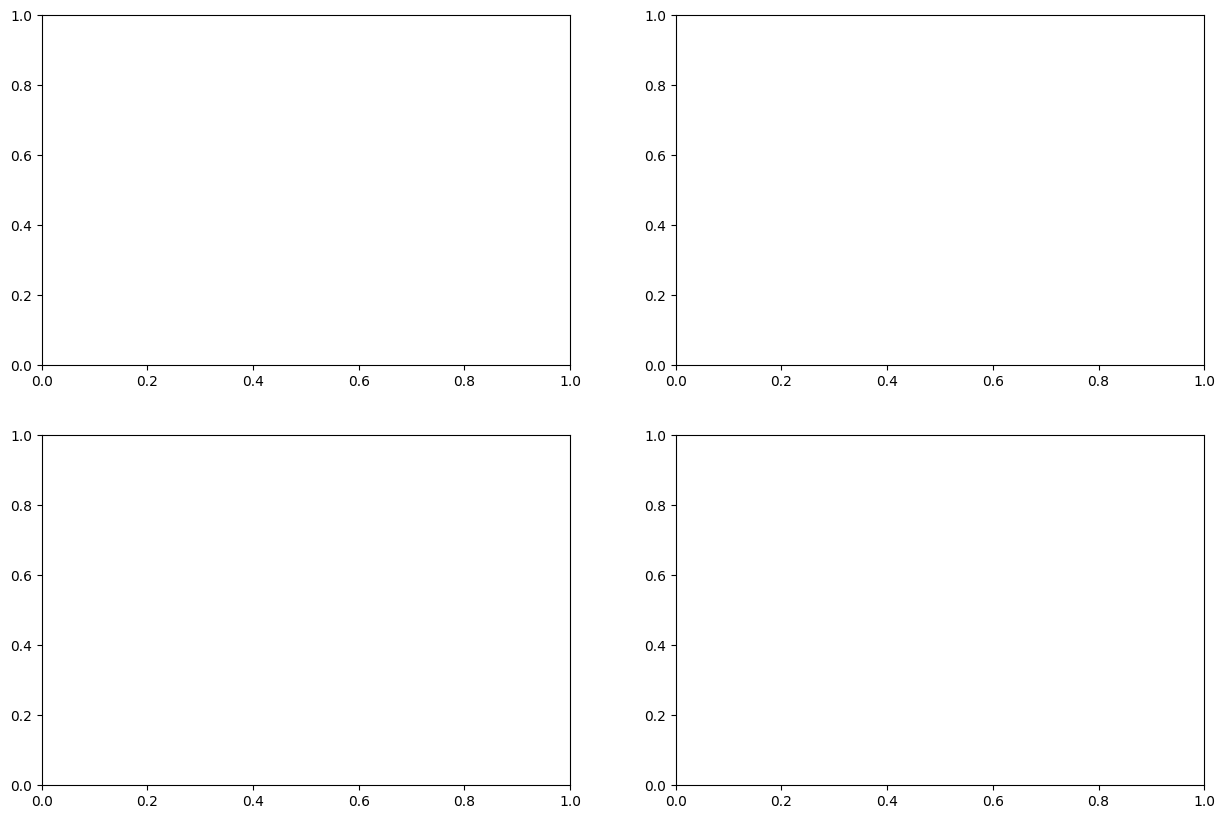

In [12]:
# Plot ResNet50 Training History
print("📊 Plotting ResNet50 training history...")

# Create comprehensive training plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# 1. Loss plot
ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('ResNet50 Training and Validation Loss', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accuracy plot
train_acc_percent = [acc * 100 for acc in history['train_accuracy']]
val_acc_percent = [acc * 100 for acc in history['val_accuracy']]

ax2.plot(epochs, train_acc_percent, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(epochs, val_acc_percent, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('ResNet50 Training and Validation Accuracy', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Learning rate plot
# ax3.plot(epochs, history['learning_rates'], 'g-', linewidth=2)
# ax3.set_title('ResNet50 Learning Rate Schedule', fontweight='bold')
# ax3.set_xlabel('Epoch')
# ax3.set_ylabel('Learning Rate')
# ax3.set_yscale('log')
ax3.grid(True, alpha=0.3)

# 4. Training dynamics plot (gap between train and val accuracy)
accuracy_gap = [train - val for train, val in zip(train_acc_percent, val_acc_percent)]
ax4.plot(epochs, accuracy_gap, 'purple', linewidth=2)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Training-Validation Accuracy Gap', fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Gap (%)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training statistics
print(f"\n📈 ResNet50 Training Statistics:")
print(f"   Initial Training Loss: {history['train_loss'][0]:.4f}")
print(f"   Final Training Loss: {history['train_loss'][-1]:.4f}")
print(f"   Loss Reduction: {((history['train_loss'][0] - history['train_loss'][-1]) / history['train_loss'][0] * 100):.1f}%")
print(f"   ")
print(f"   Initial Validation Accuracy: {history['val_accuracy'][0] * 100:.2f}%")
print(f"   Final Validation Accuracy: {history['val_accuracy'][-1] * 100:.2f}%")
print(f"   Best Validation Accuracy: {max(history['val_accuracy']) * 100:.2f}%")
print(f"   ")
# print(f"   Learning Rate Range: {min(history['learning_rates']):.2e} to {max(history['learning_rates']):.2e}")

# Compare with multi-stream results if available
if 'evaluation_results' in locals() and evaluation_results:
    print(f"\n🔄 Comparison with Multi-Stream Models:")
    
    if 'base' in evaluation_results:
        base_acc = evaluation_results['base']['accuracy'] * 100
        resnet_gap = test_accuracy - base_acc
        print(f"   ResNet50 vs BaseMultiChannel: {resnet_gap:+.2f}% difference")
    
    if 'resnet' in evaluation_results:
        multi_resnet_acc = evaluation_results['resnet']['accuracy'] * 100
        resnet_gap = test_accuracy - multi_resnet_acc
        print(f"   ResNet50 vs MultiChannelResNet: {resnet_gap:+.2f}% difference")
        
        if resnet_gap > 0:
            print(f"   ✅ Single-stream ResNet50 outperformed multi-stream by {resnet_gap:.2f}%")
        else:
            print(f"   ⚡ Multi-stream ResNet outperformed single-stream by {-resnet_gap:.2f}%")

print(f"\n✅ ResNet50 baseline analysis complete!")
print(f"   This provides a strong single-stream baseline for comparison")

## Creating DataLoaders for Pre-processed RGB + Brightness Data

Since we already have separate RGB and brightness tensors, we need to use `AugmentedMultiStreamDataset` which is designed for this scenario.

In [ ]:
from src.data_utils import AugmentedMultiStreamDataset, MultiStreamDataLoader, CIFAR100Augmentation

# Create augmentation for training (disable for validation)
train_augmentation = CIFAR100Augmentation(
    enabled=True,
    apply_to_brightness=True,  # Apply same spatial transforms to both streams
    verbose=True
)

# Create datasets using your pre-processed RGB + Brightness tensors
print("Creating multi-stream datasets...")

# Training dataset with augmentation
train_dataset = AugmentedMultiStreamDataset(
    color_data=train_color,      # Your RGB tensor [N, 3, 32, 32]
    brightness_data=train_brightness,  # Your brightness tensor [N, 1, 32, 32]
    labels=train_labels,         # Your labels [N]
    augmentation=train_augmentation,
    train=True,
    verbose=True
)

# Validation dataset without augmentation
val_dataset = AugmentedMultiStreamDataset(
    color_data=val_color,
    brightness_data=val_brightness,
    labels=val_labels,
    augmentation=None,  # No augmentation for validation
    train=False,
    verbose=True
)

# Test dataset without augmentation
test_dataset = AugmentedMultiStreamDataset(
    color_data=test_color,
    brightness_data=test_brightness,
    labels=test_labels,
    augmentation=None,  # No augmentation for test
    train=False,
    verbose=True
)

print(f"\n✅ Datasets created:")
print(f"   Training: {len(train_dataset)} samples")
print(f"   Validation: {len(val_dataset)} samples") 
print(f"   Test: {len(test_dataset)} samples")

In [ ]:
from src.data_utils import collate_with_streams

# Define a custom collate function for pre-processed dual-stream data
def dual_stream_collate(batch):
    """
    Custom collate function for datasets that already have RGB + Brightness.
    
    Args:
        batch: List of tuples from AugmentedMultiStreamDataset
               Each item: {'color': rgb_tensor, 'brightness': brightness_tensor, 'target': label}
    
    Returns:
        Tuple of (rgb_batch, brightness_batch, labels_batch)
    """
    import torch
    
    rgb_batch = []
    brightness_batch = []
    labels_batch = []
    
    for item in batch:
        rgb_batch.append(item['color'])
        brightness_batch.append(item['brightness'])
        labels_batch.append(item['target'])
    
    return (
        torch.stack(rgb_batch),      # [B, 3, H, W]
        torch.stack(brightness_batch), # [B, 1, H, W]
        torch.tensor(labels_batch, dtype=torch.long)  # [B]
    )

# Create DataLoaders with the custom collate function
print("Creating DataLoaders...")

train_loader = MultiStreamDataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # Set to 0 for notebook compatibility
    collate_fn=dual_stream_collate  # Use our custom collate for pre-processed data
)

val_loader = MultiStreamDataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=dual_stream_collate
)

test_loader = MultiStreamDataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn=dual_stream_collate
)

print(f"✅ DataLoaders created:")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

In [ ]:
# Import necessary modules for ResNet50 training
from torch.utils.data import Dataset, DataLoader, TensorDataset
from src.models2.common.model_helpers import create_dataloader_from_tensors
from sklearn.model_selection import train_test_split
from src.models2.core.resnet import resnet50

# Test the DataLoader to make sure it works correctly
print("Testing DataLoader with pre-processed dual-stream data...")

# Get a batch from the training loader
rgb_batch, brightness_batch, labels_batch = next(iter(train_loader))

print(f"\n📊 Batch from DataLoader:")
print(f"   RGB batch shape: {rgb_batch.shape}")  # Should be [batch_size, 3, 32, 32]
print(f"   Brightness batch shape: {brightness_batch.shape}")  # Should be [batch_size, 1, 32, 32]
print(f"   Labels shape: {labels_batch.shape}")  # Should be [batch_size]
print(f"   RGB data type: {rgb_batch.dtype}")
print(f"   Brightness data type: {brightness_batch.dtype}")
print(f"   Labels data type: {labels_batch.dtype}")

# Verify data ranges
print(f"\n🔍 Data ranges:")
print(f"   RGB: min={rgb_batch.min():.3f}, max={rgb_batch.max():.3f}")
print(f"   Brightness: min={brightness_batch.min():.3f}, max={brightness_batch.max():.3f}")
print(f"   Labels: min={labels_batch.min()}, max={labels_batch.max()}")

print(f"\n✅ DataLoader working correctly! Ready for training.")
print(f"💡 Usage: for rgb_batch, brightness_batch, labels in train_loader: ...")

In [15]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from src.data_utils import load_cifar100_data
from src.models2.common.model_helpers import create_dataloader_from_tensors
from src.data_utils import RGBtoRGBL
from sklearn.model_selection import train_test_split
from src.models2.core.resnet import resnet50

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
    print("🚀 Using Apple Metal Performance Shaders (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Using CPU")

batch_size = 32

train_data, train_labels, test_data, test_labels = load_cifar100_data(
    data_dir="../data/cifar-100",
    normalize=True  # Apply normalization to [0, 1] range
)

# Split the data
train_color, val_color, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.1, random_state=42
)

rgb_to_rgbl = RGBtoRGBL()
# Convert to brightness channels
train_brightness = rgb_to_rgbl.get_brightness(train_color)
val_brightness = rgb_to_rgbl.get_brightness(val_color)  
test_brightness = rgb_to_rgbl.get_brightness(test_data)

print(f"Training samples: {len(train_color)}")
print(f"Validation samples: {len(val_color)}")
print(f"Test samples: {len(test_data)}")
print(f"Number of classes: {len(torch.unique(train_labels))}")
print(f"Data shape - RGB: {train_color.shape}, Brightness: {train_brightness.shape}")
print(f"Labels shape: {train_labels.shape}")
print(f"Data range - RGB: [{train_color.min():.3f}, {train_color.max():.3f}], Brightness: [{train_brightness.min():.3f}, {train_brightness.max():.3f}]")


# Create DataLoaders for ResNet50 training (RGB only)
print("Creating DataLoaders for ResNet50...")

# Use only color data for standard ResNet training
train_loader = create_dataloader_from_tensors(
    train_color, train_labels, batch_size=batch_size, shuffle=True, device=device
)

val_loader = create_dataloader_from_tensors(
    val_color, val_labels, batch_size=batch_size*2, shuffle=False, device=device
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")
print("DataLoaders created successfully!")


# Create and train ResNet50 model with proper settings
print("Creating ResNet50 model...")
resnet50_baseline = resnet50(num_classes=100, device=str(device))

# Compile with proper learning rate and stable scheduler
print("Compiling model with optimized settings...")
resnet50_baseline.compile(
    optimizer='sgd',
    loss='cross_entropy',
    learning_rate=0.01,  # Much lower learning rate
    weight_decay=1e-4,   # Standard weight decay
    scheduler='oneCycle',    # Stable step scheduler instead of onecycle
)

print("Starting training...")
# Train with step scheduler parameters
history = resnet50_baseline.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    early_stopping=True,
    patience=5,
    verbose=True,
)

print("Training completed!")
print(f"Best validation accuracy: {max(history['val_accuracy']):.4f}")
print(f"Final train accuracy: {history['train_accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history['val_accuracy'][-1]:.4f}")

🚀 Using Apple Metal Performance Shaders (MPS)
📁 Loading CIFAR-100 from: ../data/cifar-100
✅ Loaded CIFAR-100 (torch format):
   Training: torch.Size([50000, 3, 32, 32]), labels: 50000
   Test: torch.Size([10000, 3, 32, 32]), labels: 10000
Training samples: 45000
Validation samples: 5000
Test samples: 10000
Number of classes: 100
Data shape - RGB: torch.Size([45000, 3, 32, 32]), Brightness: torch.Size([45000, 1, 32, 32])
Labels shape: torch.Size([45000])
Data range - RGB: [0.000, 1.000], Brightness: [0.000, 1.000]
Creating DataLoaders for ResNet50...


Epoch 1/10:   0%|          | 0/1486 [04:44<?, ?it/s]

: 